In [71]:
import pandas as pd
import numpy as np
import itertools
from os import path
import pickle
import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier

from sklearn.feature_selection import RFE, f_classif

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Data Import

In [3]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

### Data Prep

In [4]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [5]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [6]:
X_train = feature_prep.fit_transform(data['train'])
X_test = feature_prep.transform(data['test'])

In [7]:
y_train = data['train_target']['default'].values
y_test = data['test_target']['default'].values

### Scoring

In [8]:
f2_score = make_scorer(fbeta_score, beta=2)

### Final Models

In [9]:
models = {}

In [10]:
# Logistic Regression
lr = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                    ('estimator', LogisticRegression(class_weight='balanced', C=1e-8))])

models['lr'] = lr

# Bagged Logistic Regression
lr_bag = Pipeline([('rfe', RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=28)),
                    ('estimator', BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced', C=1e-8),
                                                   max_samples=0.2, max_features=0.8, bootstrap_features=True, bootstrap=True,
                                                   n_estimators=10, random_state=998))])

models['lr_bag'] = lr_bag

In [11]:
# Linear SVC
lsvc = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced', dual=False), n_features_to_select=31)),
                      ('estimator', LinearSVC(class_weight='balanced', dual=False, C=1e-7, ))])

models['lsvc'] = lsvc

# Bagged Linear SVC
lsvc_bag = BaggingClassifier(base_estimator=LinearSVC(class_weight='balanced', dual=False, C=1e-7),
                             n_estimators=10, max_samples=0.2, max_features=0.8,
                             bootstrap_features=False, bootstrap=False,
                             random_state=521)

models['lsvc_bag'] = lsvc_bag

In [12]:
# Decision Tree
dtc = DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=0.4, random_state=356)

models['dtc'] = dtc

# Bagged Decision Tree
dtc_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
                            bootstrap=False, bootstrap_features=False, 
                            max_features=0.7, max_samples=0.2,
                            n_estimators=10, random_state=321)

models['dtc_bag'] = dtc_bag

In [13]:
# Random Forest
rfc = RandomForestClassifier(class_weight='balanced', max_features=0.5, min_samples_leaf=.095,
                                  n_estimators=10, random_state=808)

models['rfc'] = rfc

# Bagged Random Forest
rfc_bag = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=0.05),
                                 max_features=0.2, max_samples=0.3,
                                 n_estimators=10, random_state=748)

models['rfc_bag'] = rfc_bag

In [14]:
# Bagged Gaussian Naive Bayes
gnb_bag = BaggingClassifier(base_estimator=GaussianNB(),
                                 max_features=0.5, max_samples=0.2,
                                 n_estimators=50)

models['gnb_bag'] = gnb_bag

In [15]:
# Hard Voting Classifier
vc_hard_estimators = [('lr', lr),
                   ('lsvc', lsvc), ('lsvc_bag', lsvc_bag),
                   ('dtc', dtc), ('dtc_bag_best', dtc_bag),
                   ('rfc_bag', rfc_bag),
                   ('gnb', gnb_bag)]

vc_hard_w = (1, 0.5, 0.5, 0.5, 1, 0.5, 0.5)

vc_hard = VotingClassifier(estimators=vc_hard_estimators, voting='hard', weights=vc_hard_w, n_jobs=4)

models['vc_hard'] = vc_hard

In [16]:
# Soft Voting Classifier
vc_soft_estimators = [('lr', lr), ('lr_bag', lr_bag),
                   ('dtc', dtc), ('dtc_bag_best', dtc_bag),
                   ('rfc_bag', rfc_bag),
                   ('gnb', gnb_bag)]

vc_soft_w = (1, 0.5, 1, 0.5, 1, 0.5)

vc_soft = VotingClassifier(estimators=vc_soft_estimators, voting='soft', weights=vc_soft_w, n_jobs=4)

models['vc_soft'] = vc_soft

In [17]:
df_models = pd.DataFrame()

In [18]:
df_models['label'] = models
df_models['estimator'] = df_models['label'].apply(lambda x: models[x])

### Cross-Validation Performance

In [25]:
my_func.run_time(reset=True)
model_scores = {}
n=5
l = len(df_models)
for m, model in enumerate(df_models.iterrows()):
    est = model[1]['estimator']
    skf = StratifiedKFold(n_splits=n)
    scores = {}
    scores['recall'] = []
    scores['precision']= []
    scores['specificity'] = []
    scores['f2'] = []
    for i, (i_train, i_val) in enumerate(skf.split(X_train, y_train)):
        print('\rProcessing model: \'{}\' ({}/{})... Fold {}/{}... Fitting... [ {}]{}'.format(model[0], m+1, l, i+1,n,my_func.run_time(print_time=False, return_time=True),' '*20), end='')
        est.fit(X_train[i_train], y_train[i_train])
        print('\rProcessing model: \'{}\' ({}/{})... Fold {}/{}... Predicting... [ {}]{}'.format(model[0], m+1, l, i+1,n,my_func.run_time(print_time=False, return_time=True),' '*20), end='')
        pred = est.predict(X_train[i_val])
        print('\rProcessing model: \'{}\' ({}/{})... Fold {}/{}... Scoring... [ {}]{}'.format(model[0], m+1, l, i+1,n,my_func.run_time(print_time=False, return_time=True),' '*20), end='')
        scores['recall'].append(recall_score(y_train[i_val], pred))
        scores['precision'].append(precision_score(y_train[i_val], pred))
        scores['specificity'].append(my_func.binary_specificity(y_train[i_val], pred))
        scores['f2'].append(fbeta_score(y_train[i_val], pred, beta=2))
    print(("\rModel '{}' completed... {}".format(model[0],' '*100)))
    score_summary = {}
    for score_label, score_list in scores.items():
        score_summary[score_label + '_mean'] = np.mean(score_list)
        score_summary[score_label + '_std'] = np.std(score_list)
    
    scores = {**scores, **score_summary}
    model_scores[model[0]] = scores
print('Completed {}/{} [ {}]{}'.format(l,l,my_func.run_time(return_time=True, print_time=False), ' '*100))

Model 'dtc' completed...                                                                                                     
Model 'dtc_bag' completed...                                                                                                     
Model 'gnb_bag' completed...                                                                                                     
Model 'lr' completed...                                                                                                     
Model 'lr_bag' completed...                                                                                                     
Model 'lsvc' completed...                                                                                                     
Model 'lsvc_bag' completed...                                                                                                     
Model 'rfc' completed...                                                                              

In [26]:
df_models['cv_recall'] = df_models.apply(lambda x: model_scores[x['label']]['recall_mean'], axis=1)
df_models['cv_precision'] = df_models.apply(lambda x: model_scores[x['label']]['precision_mean'], axis=1)
df_models['cv_specificity'] = df_models.apply(lambda x: model_scores[x['label']]['specificity_mean'], axis=1)
df_models['cv_f2'] = df_models.apply(lambda x: model_scores[x['label']]['f2_mean'], axis=1)

In [27]:
df_models

,label,estimator,cv_recall,cv_precision,cv_specificity,cv_f2
dtc,lr,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.736626,0.279647,0.548176,0.555178
dtc_bag,lr_bag,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.726242,0.274840,0.543451,0.546517
gnb_bag,lsvc,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.688119,0.274789,0.566876,0.528628
lr,lsvc_bag,"(LinearSVC(C=1e-07, class_weight='balanced', d...",0.716643,0.275415,0.549852,0.542141
lr_bag,dtc,DecisionTreeClassifier(class_weight='balanced'...,0.760743,0.274584,0.521416,0.561798
lsvc,dtc_bag,(DecisionTreeClassifier(class_weight='balanced...,0.754219,0.270317,0.515210,0.555363
lsvc_bag,rfc,"(DecisionTreeClassifier(class_weight=None, cri...",0.667896,0.280434,0.591847,0.523273
rfc,rfc_bag,"((DecisionTreeClassifier(class_weight=None, cr...",0.743762,0.257966,0.454347,0.525353
rfc_bag,gnb_bag,"(GaussianNB(priors=None), GaussianNB(priors=No...",0.753467,0.276962,0.531551,0.560544
vc_hard,vc_hard,"VotingClassifier(estimators=[('lr', Pipeline(m...",0.748788,0.278402,0.537643,0.559490


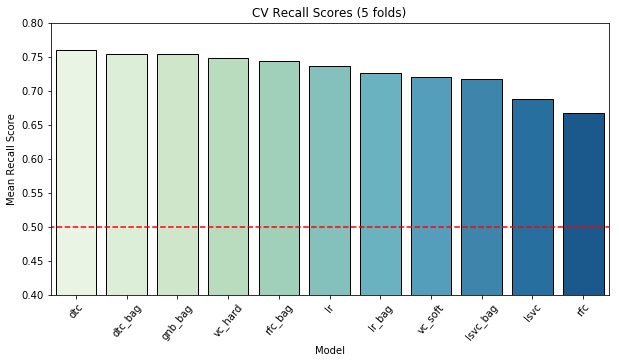

In [106]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('cv_recall', ascending=False), x='label', y='cv_recall', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.4,0.8)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('CV Recall Scores (5 folds)')
ax.set_xlabel('Model')
ax.set_ylabel('Mean Recall Score')

my_func.saveplot(plt, 'Eval_BarChart_ValRecall')

plt.show()

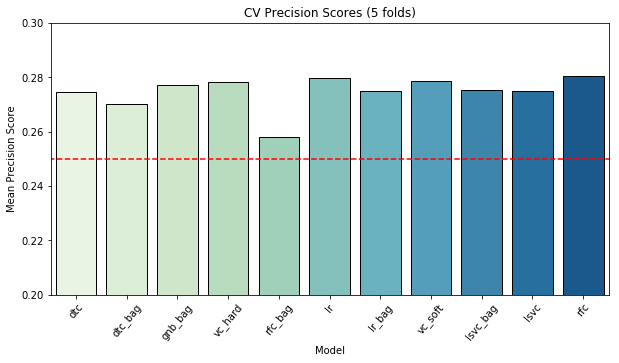

In [107]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('cv_recall', ascending=False), x='label', y='cv_precision', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.20,0.30)
ax.hlines(0.25, -1,11, colors='r', linestyles='dashed')
ax.set_title('CV Precision Scores (5 folds)')
ax.set_xlabel('Model')
ax.set_ylabel('Mean Precision Score')

my_func.saveplot(plt, 'Eval_BarChart_ValPrecision')
plt.show()

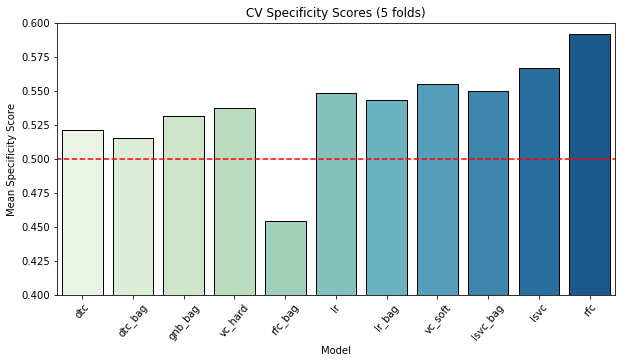

In [108]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('cv_recall', ascending=False), x='label', y='cv_specificity', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.40,0.60)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('CV Specificity Scores (5 folds)')
ax.set_xlabel('Model')
ax.set_ylabel('Mean Specificity Score')

my_func.saveplot(plt, 'Eval_BarChart_ValSpecificity')
plt.show()

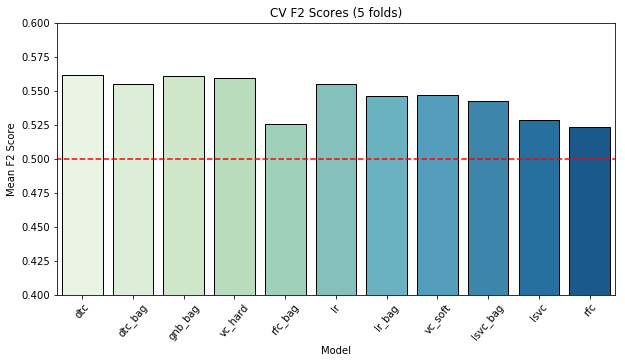

In [109]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('cv_recall', ascending=False), x='label', y='cv_f2', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.4,0.6)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('CV F2 Scores (5 folds)')
ax.set_xlabel('Model')
ax.set_ylabel('Mean F2 Score')

my_func.saveplot(plt, 'Eval_BarChart_ValF2')
plt.show()

### Test Performance

In [46]:
my_func.run_time(reset=True)

test_scores = {}
l = len(df_models)
for m, model in enumerate(df_models.iterrows()):
    est = model[1]['estimator']
    scores = {}
    print('\rProcessing model: \'{}\' ({}/{})... Fitting... [ {}]{}'.format(model[0], m+1, l, my_func.run_time(print_time=False, return_time=True),' '*20), end='')
    est.fit(X_train, y_train)
    print('\rProcessing model: \'{}\' ({}/{})... Predicting... [ {}]{}'.format(model[0], m+1, l, my_func.run_time(print_time=False, return_time=True),' '*20), end='')
    pred = est.predict(X_test)
    print('\rProcessing model: \'{}\' ({}/{})... Scoring... [ {}]{}'.format(model[0], m+1, l, my_func.run_time(print_time=False, return_time=True),' '*20), end='')
    scores['recall'] = recall_score(y_test, pred)
    scores['precision'] = precision_score(y_test, pred)
    scores['specificity'] = my_func.binary_specificity(y_test, pred)
    scores['f2'] = fbeta_score(y_test, pred, beta=2)
    
    test_scores[model[0]] = scores
    print(("\rModel '{}' completed... {}".format(model[0],' '*80)))
print('Completed {}/{} [ {}]{}'.format(l,l,my_func.run_time(return_time=True, print_time=False), ' '*80))

Model 'dtc' completed...                                                                                 
Model 'dtc_bag' completed...                                                                                 
Model 'gnb_bag' completed...                                                                                 
Model 'lr' completed...                                                                                 
Model 'lr_bag' completed...                                                                                 
Model 'lsvc' completed...                                                                                 
Model 'lsvc_bag' completed...                                                                                 
Model 'rfc' completed...                                                                                 
Model 'rfc_bag' completed...                                                                                 
Model 'vc_hard' completed.

In [50]:
df_models['test_recall'] = df_models.apply(lambda x: test_scores[x['label']]['recall'], axis=1)
df_models['test_precision'] = df_models.apply(lambda x: test_scores[x['label']]['precision'], axis=1)
df_models['test_specificity'] = df_models.apply(lambda x: test_scores[x['label']]['specificity'], axis=1)
df_models['test_f2'] = df_models.apply(lambda x: test_scores[x['label']]['f2'], axis=1)

In [51]:
df_models

,label,estimator,cv_recall,cv_precision,cv_specificity,cv_f2,test_recall,test_precision,test_specificity,test_f2
dtc,lr,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.736626,0.279647,0.548176,0.555178,0.735653,0.272704,0.547885,0.549189
dtc_bag,lr_bag,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.726242,0.274840,0.543451,0.546517,0.737477,0.269317,0.538929,0.547226
gnb_bag,lsvc,"Pipeline(memory=None,\n steps=[('rfe', RFE...",0.688119,0.274789,0.566876,0.528628,0.681212,0.269363,0.574205,0.521684
lr,lsvc_bag,"(LinearSVC(C=1e-07, class_weight='balanced', d...",0.716643,0.275415,0.549852,0.542141,0.752070,0.259376,0.505141,0.545015
lr_bag,dtc,DecisionTreeClassifier(class_weight='balanced'...,0.760743,0.274584,0.521416,0.561798,0.760067,0.267625,0.520693,0.555601
lsvc,dtc_bag,(DecisionTreeClassifier(class_weight='balanced...,0.754219,0.270317,0.515210,0.555363,0.745054,0.264219,0.521890,0.546240
lsvc_bag,rfc,"(DecisionTreeClassifier(class_weight=None, cri...",0.667896,0.280434,0.591847,0.523273,0.645012,0.275881,0.609868,0.508844
rfc,rfc_bag,"((DecisionTreeClassifier(class_weight=None, cr...",0.743762,0.257966,0.454347,0.525353,0.577803,0.291808,0.676862,0.483107
rfc_bag,gnb_bag,"(GaussianNB(priors=None), GaussianNB(priors=No...",0.753467,0.276962,0.531551,0.560544,0.753894,0.269067,0.528065,0.554180
vc_hard,vc_hard,"VotingClassifier(estimators=[('lr', Pipeline(m...",0.748788,0.278402,0.537643,0.559490,0.728638,0.276857,0.561433,0.549349


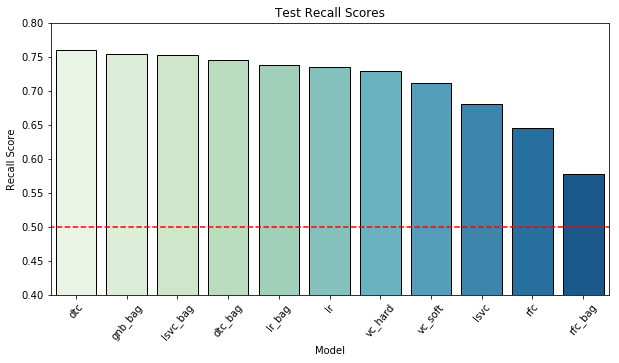

In [114]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('test_recall', ascending=False), x='label', y='test_recall', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.4,0.8)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('Test Recall Scores')
ax.set_xlabel('Model')
ax.set_ylabel('Recall Score')

my_func.saveplot(plt, 'Eval_BarChart_TestRecall')
plt.show()

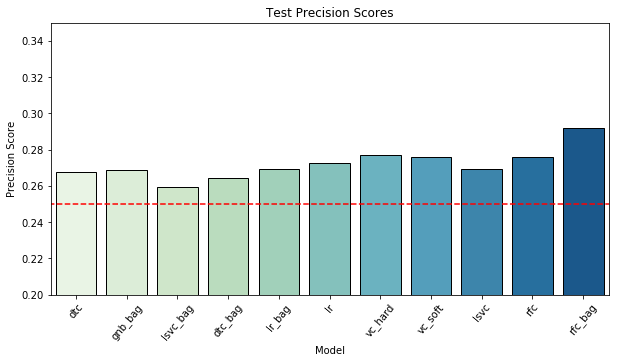

In [115]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('test_recall', ascending=False), x='label', y='test_precision', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.20,0.35)
ax.hlines(0.25, -1,11, colors='r', linestyles='dashed')
ax.set_title('Test Precision Scores')
ax.set_xlabel('Model')
ax.set_ylabel('Precision Score')

my_func.saveplot(plt, 'Eval_BarChart_TestPrecision')
plt.show()

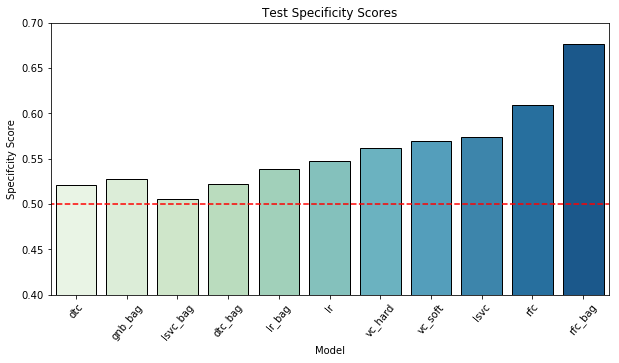

In [116]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('test_recall', ascending=False), x='label', y='test_specificity', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.40,0.7)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('Test Specificity Scores')
ax.set_xlabel('Model')
ax.set_ylabel('Specifcity Score')

my_func.saveplot(plt, 'Eval_BarChart_TestSpecificity')
plt.show()

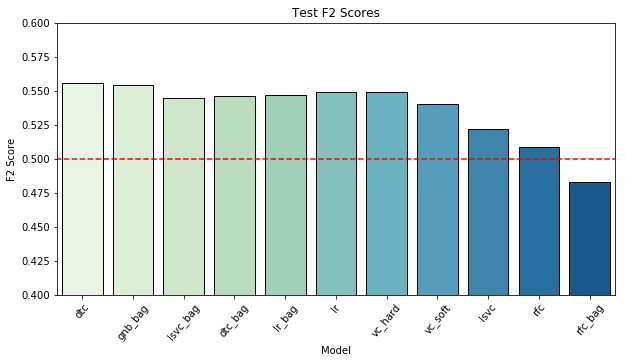

In [117]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_models.sort_values('test_recall', ascending=False), x='label', y='test_f2', palette='GnBu', edgecolor='k')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylim(0.40,0.6)
ax.hlines(0.5, -1,11, colors='r', linestyles='dashed')
ax.set_title('Test F2 Scores')
ax.set_xlabel('Model')
ax.set_ylabel('F2 Score')

my_func.saveplot(plt, 'Eval_BarChart_TestF2')
plt.show()

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [65]:
best_model = df_models.loc['dtc']['estimator']

In [66]:
best_model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('rfe', RFE(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [67]:
test_pred = best_model.predict(X_test)

Normalized confusion matrix
[[ 0.52069322  0.47930678]
 [ 0.23993265  0.76006735]]


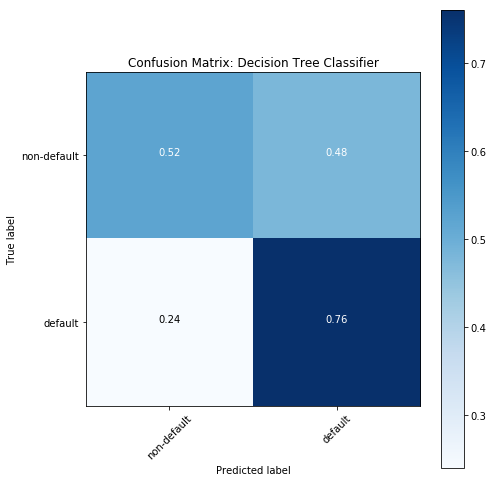

In [123]:
conf_mat = confusion_matrix(y_pred=test_pred, y_true=y_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cm=conf_mat, classes=['non-default', 'default'], normalize=True, title='Confusion Matrix: Decision Tree Classifier');

my_func.saveplot(plt, 'Eval_ConfMat_DTC_Norm')
plt.show()

Confusion matrix, without normalization
[[16104 14824]
 [ 1710  5417]]


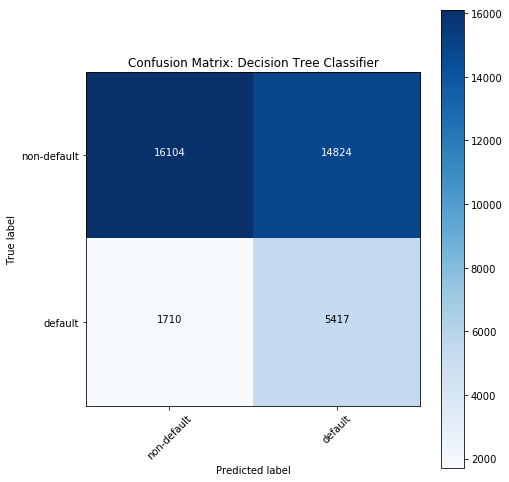

In [124]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm=conf_mat, classes=['non-default', 'default'], normalize=False, title='Confusion Matrix: Decision Tree Classifier');

my_func.saveplot(plt, 'Eval_ConfMat_DTC_Nom')
plt.show()

### Saving Models

In [93]:
f = 'models_dataframe.p'
d = ['..','models']
fp = path.join(*d,f)

with open(fp, 'wb') as file:
    pickle.dump(df_models, file)

In [94]:
f = 'best_model_dtc.p'
d = ['..','models']
fp = path.join(*d,f)

with open(fp, 'wb') as file:
    pickle.dump(best_model, file)